<a href="https://colab.research.google.com/github/charlyandral/NLP-ENSAE-2020/blob/master/Projet_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

report and data on https://github.com/charlyandral/NLP-ENSAE-2020/

# **ANALYSIS OF THE RERB TWEETS AND REPLIES**

As the famous French journal "Le Point" recently titled : "Le RER est le transport le plus anxiogène devant le métro". Indeed, the daily experience of every parisian - and especially of the ones who are lucky enough to have to commute every day from the inner city to the suburbs - is made of delays and "pannes de signalisation" which are sometimes psychologically costly. This sensitive topic is the subject of many daily informal conversations in which we can often hear that the problem is not the traffic incidents themselves, but also the lack of information surrounding them, or its unaccuracy. This study is an attempt to look at this criticized line of communication with the objective glasses of datascience : by analyzing the tweets from the RERB account and their replies with Machine Learning tools, we aim to understand the dynamics and the characteristics of the communication set up by the RERB institution, and to have a broad comprehension of the reactions it generates.


> *Installation of the transformers :*



In [3]:
!pip install transformers

     |████████████████████████████████| 573kB 7.8MB/s 
     |████████████████████████████████| 3.7MB 21.0MB/s 
     |████████████████████████████████| 870kB 56.9MB/s 
     |████████████████████████████████| 1.0MB 52.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=02c739fdbb931b15af21b7d7db19d624247acfee9457ec4955af9b7123a3d7ad
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


> *Importation of the packages :*



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("notebook")
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime as dt
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> *Importation of the data :*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We have three dataframes :

*   one containing the tweets **from** the RERB account (including their replies to other tweets and to their own tweets),
*   one containing the replies **to** the tweets of the RERB account (including the replies of the RERB account to their own tweets).
*   one containing replies which we have classified in three categories ("positive", "negative", "neutral") and which we will use for the sentiment analysis.

In [5]:
df_from = pd.read_csv("/content/drive/My Drive/tweetsFromRERB.csv",sep = ',')
df_to = pd.read_csv("/content/drive/My Drive/tweetsToRERB.csv",sep = ',')
df_class = pd.read_csv("/content/drive/My Drive/classified.csv",sep = ',')
index_with_nan = df_class.index[df_class.sentiment.isna()]
df_class.drop(index_with_nan,0, inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,7,11,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **I. Descriptive statistics**

### Data cleaning and exploration

Taking a glimpse at the data :

In [0]:
print(df_from.shape)
df_from.head()

(51291, 35)


,Unnamed: 0,Unnamed: 0.1,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,0,1248626903532965894,1248626901922373632,1586530826000,2020-04-10 15:00:26,UTC,NaN,Une carte interactive de vos bus de substituti...,['#rerb'],[],1259475811,1259475811,RERB,RER B,5,15,https://twitter.com/RERB/status/12486269035329...,False,0,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}]",NaN,NaN,NaN,NaN
1,1,1,1248626901922373632,1248626901922373632,1586530826000,2020-04-10 15:00:26,UTC,NaN,"[Pandémie #COVID19] : Ce week-end, samedi 11 e...","['#covid19', '#rerb']",[],1259475811,1259475811,RERB,RER B,5,15,https://twitter.com/RERB/status/12486269019223...,False,0,1,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}]",NaN,NaN,NaN,NaN
2,2,2,1248567925226844160,1248567924081778688,1586516765000,2020-04-10 11:06:05,UTC,NaN,ℹ️Dernier départ de St-Rémy pour CDG2: 20h30\n...,[],[],1259475811,1259475811,RERB,RER B,5,11,https://twitter.com/RERB/status/12485679252268...,False,0,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}]",NaN,NaN,NaN,NaN
3,3,3,1248567924081778688,1248567924081778688,1586516765000,2020-04-10 11:06:05,UTC,NaN,"Derniers départs, ce soir : \nℹ️Dernier départ...",[],[],1259475811,1259475811,RERB,RER B,5,11,https://twitter.com/RERB/status/12485679240817...,False,3,1,2,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}]",NaN,NaN,NaN,NaN
4,4,4,1248535655023591424,1248459053069512705,1586509071000,2020-04-10 08:57:51,UTC,NaN,"Bonjour, merci beaucoup pour votre message (et...",[],[],1259475811,1259475811,RERB,RER B,5,8,https://twitter.com/RERB/status/12485356550235...,False,0,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}...",NaN,NaN,NaN,NaN


In [0]:
print(df_to.shape)
df_to.head()

(132996, 35)


,Unnamed: 0,Unnamed: 0.1,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,0,1.24869e+18,1.24869e+18,1.586545e+12,2020-04-10 18:57:20,UTC,NaN,@RERB il attend quoi ce rer de malheur pour re...,[],[],2.7043e+08,2.704297e+08,RVD92i,RVD,5.0,18,https://twitter.com/RVD92i/status/124868652130...,False,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '270429710', 'username': 'RVD92i'...",NaN,NaN,NaN,NaN
1,1,1,1.24863e+18,1.24863e+18,1.586532e+12,2020-04-10 15:17:54,UTC,NaN,@RERB merci à la « voix » en gare d’Aulnay qui...,[],[],4.7762e+08,4.776197e+08,nathvallet,Nath Vallet-P,5.0,15,https://twitter.com/nathvallet/status/12486312...,False,1.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '477619661', 'username': 'nathval...",NaN,NaN,NaN,NaN
2,2,2,1.24863e+18,1.24863e+18,1.586531e+12,2020-04-10 15:00:26,UTC,NaN,Une carte interactive de vos bus de substituti...,['#rerb'],[],1.25948e+09,1.259476e+09,RERB,RER B,5.0,15,https://twitter.com/RERB/status/12486269035329...,False,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}]",NaN,NaN,NaN,NaN
3,3,3,1.24857e+18,1.24857e+18,1.586517e+12,2020-04-10 11:06:05,UTC,NaN,ℹ️Dernier départ de St-Rémy pour CDG2: 20h30\n...,[],[],1.25948e+09,1.259476e+09,RERB,RER B,5.0,11,https://twitter.com/RERB/status/12485679252268...,False,0.0,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1259475811', 'username': 'RERB'}]",NaN,NaN,NaN,NaN
4,4,4,1.24853e+18,1.24846e+18,1.586509e+12,2020-04-10 08:49:17,UTC,NaN,Bonjour Alexandra juste un petit message pour ...,[],[],1.08232e+18,1.082325e+18,TIME997598761,TIME99759876,5.0,8,https://twitter.com/TIME997598761/status/12485...,False,4.0,1.0,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1082324526795538432', 'username'...",NaN,NaN,NaN,NaN


In [0]:
print(df_class.shape)
df_class.head()

(3633, 3)


,Unnamed: 0,sentiment,tweet
0,67741,1.0,"Bonjour, grève pour demain ?"
1,5885,1.0,Un petit coup de vent et la régularité déjà pa...
2,40506,1.0,@RERB Bonjour...qqn a tapé ma vertèbre par acc...
3,112456,1.0,"@RERB Bonjour, pk les RER B n'ont pas de doubl..."
4,28140,0.0,@RERB quelle horreur ce putain de rer b tout m...


We start by removing the tweets of the RERB from the reply tweets, because all we are interested in is the answers from other people.

In [0]:
df_to = df_to.loc[df_to['username'] != 'RERB']
df_to.shape

(131888, 35)

In the tweets from RERB dataset, we remove the tweets that are replies to other people than to RERB, because we only want to keep the "original" tweets from the RERB account.

In [9]:
df_from["is_reply"] = df_from.reply_to.apply(eval).apply(len)>1
df_from = df_from.loc[df_from['is_reply'] == False]
df_from.shape

(18750, 39)

To what extent are original tweets from the RERB replied to ?



count    18750.000000
mean         3.479467
std          7.027424
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max        148.000000
Name: nreplies, dtype: float64
-------
0      34.064000
1      21.418667
2      10.965333
3       7.285333
4       4.970667
         ...    
65      0.005333
69      0.005333
148     0.005333
73      0.005333
70      0.005333
Name: nreplies, Length: 84, dtype: float64
-------


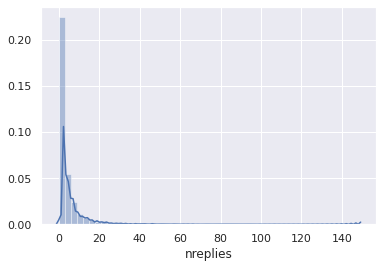

In [0]:
n = len(df_from.id)
print(df_from.nreplies.describe())
print('-------')
print((df_from.nreplies.value_counts()/n)*100)
print('-------')
sns.distplot(df_from.nreplies)

We observe that the replies are very unequally distributed among the tweets : some tweets generate a lot of replies but most of them generate 2 or less replies.
It could be interesting to study more carefully the variable 'nreplies' in order to identify which factors it depends on.

### Temporal analysis of the tweets' frequency

In this section, we try to identify which temporal scale is relevant to explain the tweets' frequency : several years, a year, a week or a day ?

In order to do so, we start by creating variables giving us, for each tweet its year, month, day and hour of publication (some of these variables are already in the dataset but not all of them).

Then we take a look at the evolution of the number of original and reply tweets, through the years, throughout the year, throughtout the week and throughout the day.


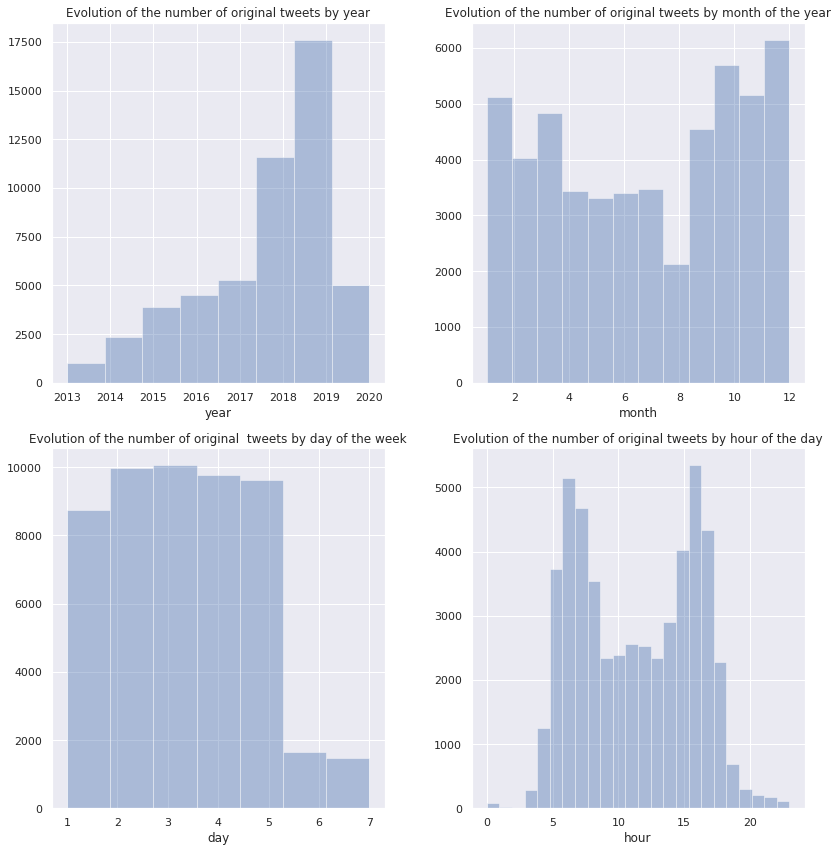

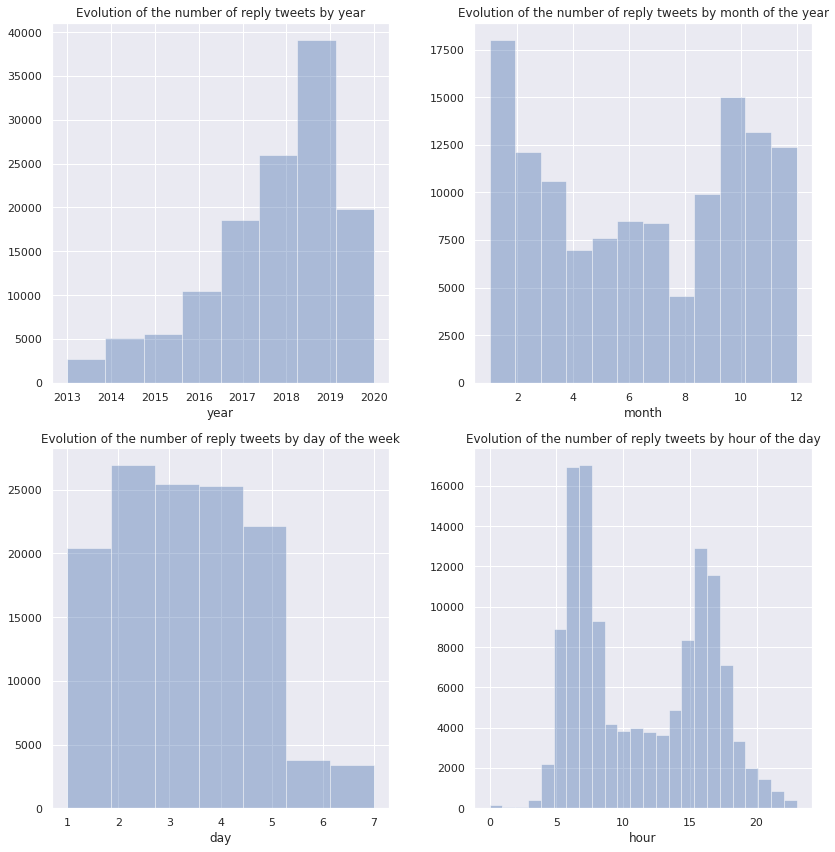

In [8]:
df_from['datetime'] = pd.to_datetime(df_from['date'])
df_from['year'] = df_from.datetime.dt.year
df_from['month'] = df_from.datetime.dt.month

# Removing reply tweets for which there's no date, hour or day

index_with_nan = df_to.index[df_to.date.isna()]
df_to.drop(index_with_nan,0, inplace=True)
index_with_nan = df_to.index[df_to.day.isna()]
df_to.drop(index_with_nan,0, inplace=True)

df_to['datetime'] = pd.to_datetime(df_to['date'])
df_to['year'] = df_to.datetime.dt.year
df_to['month'] = df_to.datetime.dt.month
df_to['hour'] = df_to.datetime.dt.hour


f, axes = plt.subplots(2, 2, figsize=(12, 12))


sns.distplot(df_from.year, bins = 8, kde = False, ax=axes[0, 0]).set_title('Evolution of the number of original tweets by year')
sns.distplot(df_from.month, bins = 12, kde = False, ax=axes[0, 1]).set_title('Evolution of the number of original tweets by month of the year')
sns.distplot(df_from.day, bins = 7, kde = False, ax=axes[1, 0]).set_title('Evolution of the number of original  tweets by day of the week')
sns.distplot(df_from.hour, bins = 24, kde = False, ax=axes[1, 1]).set_title('Evolution of the number of original tweets by hour of the day')


plt.tight_layout()

f, axes = plt.subplots(2, 2, figsize=(12, 12))


sns.distplot(df_to.year, bins = 8, kde = False, ax=axes[0, 0]).set_title('Evolution of the number of reply tweets by year')
sns.distplot(df_to.month, bins = 12, kde = False, ax=axes[0, 1]).set_title('Evolution of the number of reply tweets by month of the year')
sns.distplot(df_to.day, bins = 7, kde = False, ax=axes[1, 0]).set_title('Evolution of the number of reply tweets by day of the week')
sns.distplot(df_to.hour, bins = 24, kde = False, ax=axes[1, 1]).set_title('Evolution of the number of reply tweets by hour of the day')


plt.tight_layout()


Many conclusions are to be drawn from these graphs :


*   there is an increasing number of original tweets and replies published every year. We could wonder if this have to be associated with an increase of traffic problems on the B line or if it is just the consequence of a change in the RATP's strategy of communication,
*   we can see that the frequency of RERB tweets and replies varies with months : there is especially an increase of publication (and replies) in october and throughout all the winter, and a strong decrease in august and more globally throughout the whole summer,
*   we can also remark a strong difference between the worked days of the week and the week-ends,
*   finally, we notice that there seems to be a strong dependency between the number of tweets and the hour of the day : especially there is a strong peak in the morning and at the end of the working day. The peaks are even more salient for answers, and the morning peak is higher than the evening one. We could therefore think that people are more unhappy when they are forced to be late at work in the morning than when going home later in the evening. 

To conclude, we see that our four time-scales are relevant for the RERB tweets analysis. If we were to take the original tweets as a proxy for the incidents affecting the traffic, we could already conclude that the worst moment to be in the RERB would be on thursday of october between 4 and 5 pm, which could seem pretty plausible to the users of this line.

Before taking a closer look at the content of the tweets and their replies, we will try to have a glimpse to their general shape, and especially try to see if the evolution of their length has any interesting property.

### Descriptive analysis of the tweets' length

We start this section by creating a variable for the lenght of the tweets and replies, and observe their distributions.

count    18750.000000
mean       120.383573
std         52.620399
min          4.000000
25%         79.000000
50%        113.000000
75%        140.000000
max        411.000000
Name: len, dtype: float64
------
count    126171.000000
mean        101.955521
std          64.269999
min           1.000000
25%          54.000000
50%          92.000000
75%         135.000000
max         926.000000
Name: len, dtype: float64
------
count    18750.000000
mean       114.317493
std         48.593834
min          1.000000
25%         79.000000
50%        107.000000
75%        135.000000
max        281.000000
Name: len_clean, dtype: float64
------
count    126171.000000
mean         99.750402
std          63.737763
min           0.000000
25%          52.000000
50%          90.000000
75%         134.000000
max         295.000000
Name: len_clean, dtype: float64
------


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


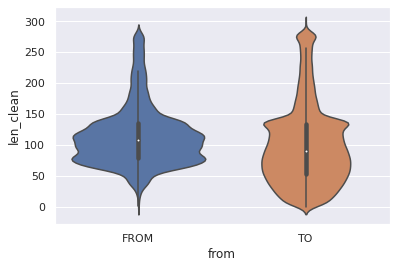

In [0]:
df_from['len'] = df_from['tweet'].apply(len)
df_to['len'] = df_to['tweet'].apply(len)

print(df_from.len.describe())
print('------')
print(df_to.len.describe())
print('------')

# There are anormally long tweets : this might be due to the presence of url or pictures in them.
# We therefore remove the url and pics from the tweets.

def remove_urls(string):
    vTEXT = re.sub(r"((http|ftp|https)://)?([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", "", string)
    return(vTEXT)

def remove_pics(string):
  return re.sub(r'pic.twitter\S+', '', string)

df_from['tweet_clean'] = df_from.tweet.apply(remove_urls).apply(remove_pics)
df_to['tweet_clean'] =df_to.tweet.apply(remove_urls).apply(remove_pics)

df_from['len_clean'] = df_from['tweet_clean'].apply(len)
df_to['len_clean'] = df_to['tweet_clean'].apply(len)

df_from['len_clean'] = df_from['len_clean'].astype(int)

print(df_from.len_clean.describe())
print('------')
print(df_to.len_clean.describe())
print('------')

# To be able to compare the histograms, we plot them on the same graph.
# We therefore merge the two dataframes

df_from['from'] = 1

df_merged = pd.concat([df_from, df_to], ignore_index=True)
df_merged['from']= df_merged['from'].fillna(0)

df_merged

df_merged['from'].loc[df_merged['from'] == 1] = 'FROM'
df_merged['from'].loc[df_merged['from'] == 0] = 'TO'
 
sns.violinplot(x="from", y="len_clean", data=df_merged)

We observe that the length of the RERB tweets is more concentrated around the value of 100 signs, whereas the reply  tweets are more uniformly distributed : there is especially a larger amount of very short tweets (which explains why the "from"-tweets' mean is higher than the "to"-tweets one), and a kind of peak at 140 signs.
The drop in the two distributions that we observe arount 140 signs is probably linked to change in the limitation of signs it an tweet which passed from 140 to 280 in november 2017.

We now wonder if there is an evolution of the tweets' length by year, month, day or hour ?

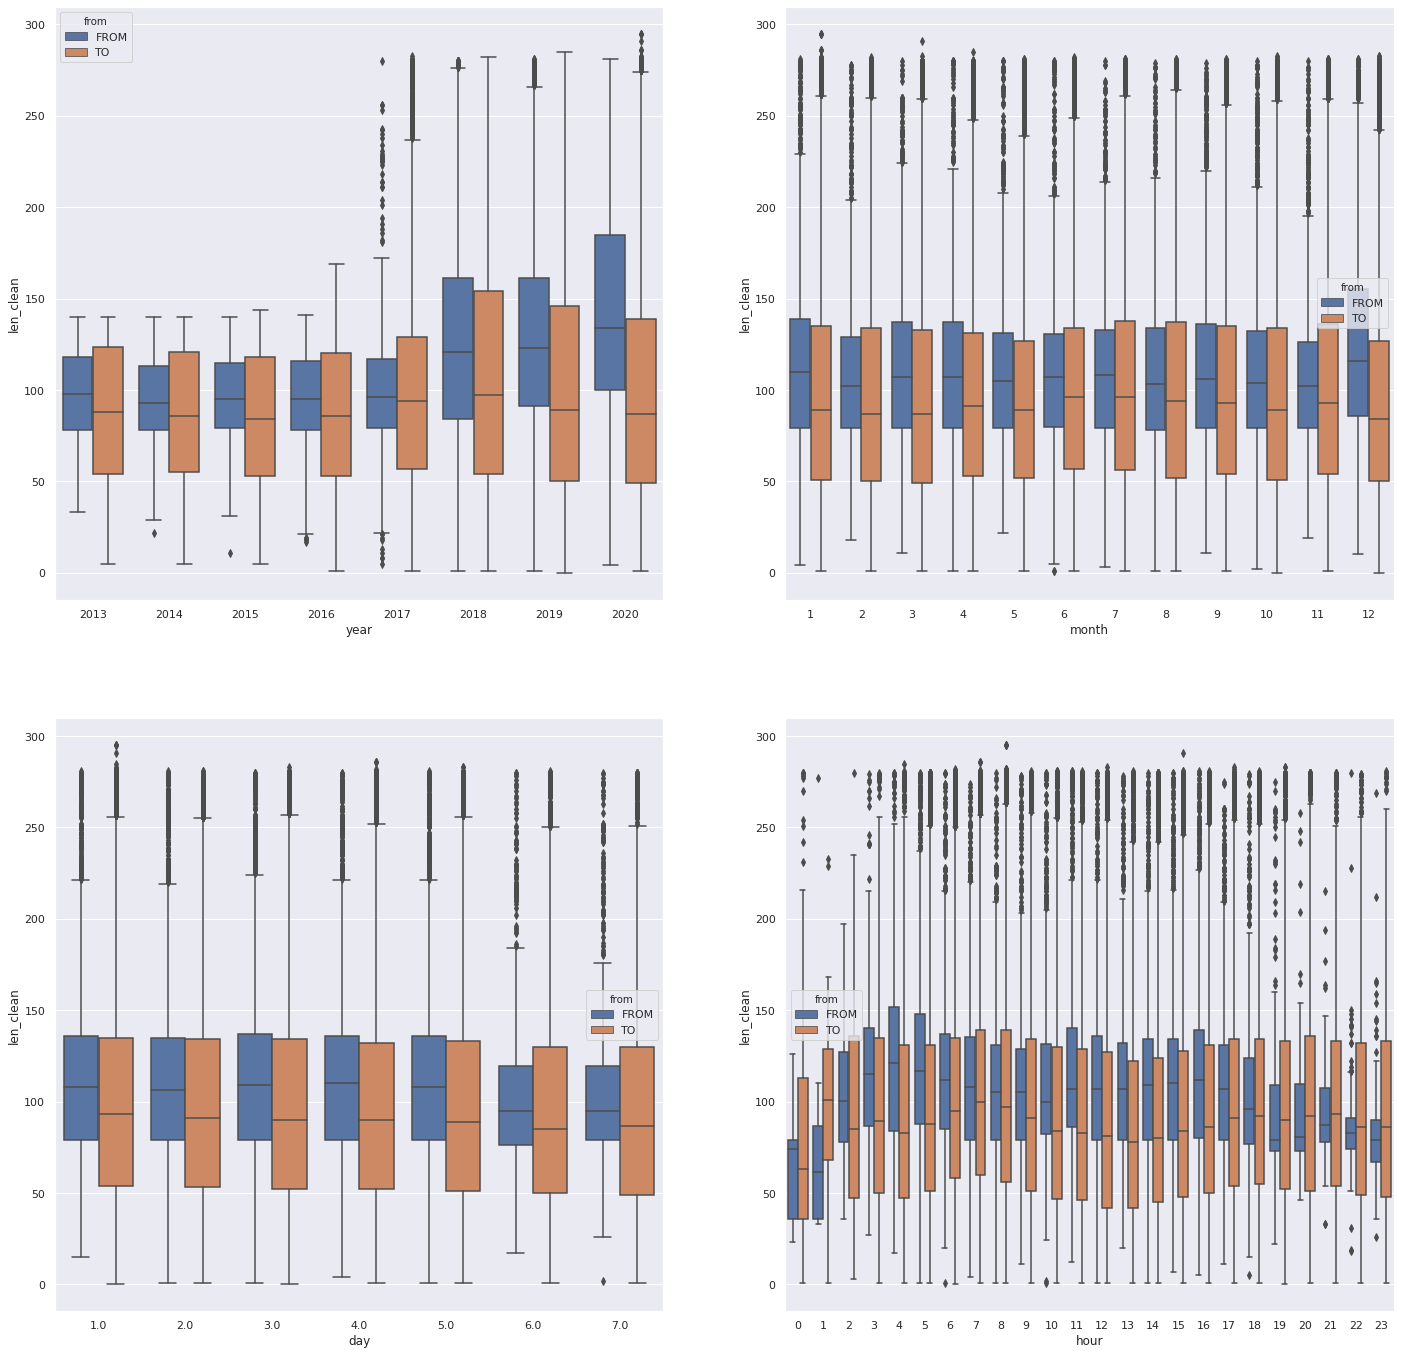

In [0]:
f, axes = plt.subplots(2, 2, figsize=(24, 24))

sns.boxplot(x="year", y="len_clean", hue="from", data=df_merged, ax = axes[0,0])
sns.boxplot(x="month", y="len_clean", hue="from", data=df_merged, ax = axes[0,1])
sns.boxplot(x="day", y="len_clean", hue="from", data=df_merged, ax = axes[1,0])
sns.boxplot(x="hour", y="len_clean", hue="from", data=df_merged, ax = axes[1,1])

The length of the tweets from and to RERB seems to be :

*   increasing and more dispersed throughout the years (especially since 2018, which must largely be linked to change of maximum number of signs in november 2017),
*   more or less constant in terms of mean and dispersion throughout the months, the days and the hours : we just observe that the length of the original tweets is much less dispersed during the week-end and that the tweets seem to be slightly longer and more dispersed during the evening rush.

Eventhough we can notice some slight temporal variations of the tweets' length at different time-scales, this analysis does not seem to reveal much of the dynamics of the RERB communication and of the reactions it generates. We will therefore go a little bit further in our analysis by looking at the most frequent words in original and reply tweets.


###First look at the vocabulary and to the most frequent words

We start this section by tokeninzing the tweets (with TweetTokenizer), removing the unrelevant tokens from the list, and constructing a dataframe giving the number of occurences for each token.


In [0]:
import nltk
from nltk.corpus import stopwords
from functools import reduce
from operator import add
from nltk.tokenize import TweetTokenizer
from collections import Counter


arr_from = df_from.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

L1=[]
for i in arr_from:
   L1+=i

arr_to = df_to.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

L2=[]
for i in arr_to:
   L2+=i

In [0]:
# we remove the polluting tokens from the list with different functions
def remove_hashtags(tokens):
  tokens = filter(lambda x : "#" not in x, tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

def remove_pic(tokens):
  tokens = filter(lambda x : "pic.twitter" not in x, tokens)
  return list(tokens)

L1 = remove_html(L1)
L1 = remove_url(L1)
L1 = remove_pic(L1)

L2 = remove_html(L2)
L2 = remove_url(L2)
L2 = remove_pic(L2)

L1 = [word.lower() for word in L1]
L2 = [word.lower() for word in L2]

nltk.download('stopwords')
L1 = [word for word in L1 if word not in stopwords.words("french")]
L2 = [word for word in L2 if word not in stopwords.words("french")]

ponctuation = [",",".","?","[","]","(",")","{","}", "/", "'", '^', '!', ';',':','’','-', '_','...','…']
L1 = [word for word in L1 if word not in ponctuation]
L2 = [word for word in L2 if word not in ponctuation]

words = ["#rerb", "@rerb", " ", '"', "#ratp", "@ratp"]
L1 = [word for word in L1 if word not in words]
L2 = [word for word in L2 if word not in words]

# Creation of the freq/occurences df
c_from = Counter(L1)
d_from = pd.DataFrame(c_from, index=['occurrences']).transpose().reset_index()
d_from.columns=['word', 'occurences']
nb_total = d_from.occurences.sum()
d_from['freq'] = d_from.occurences.apply(lambda x: x/nb_total)
d_from = d_from.sort_values('freq', ascending=False)


c_to = Counter(L2)
d_to = pd.DataFrame(c_to, index=['occurrences']).transpose().reset_index()
d_to.columns=['word', 'occurences']
nb_total = d_to.occurences.sum()
d_to['freq'] = d_to.occurences.apply(lambda x: x/nb_total)
d_to = d_to.sort_values('freq', ascending=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
print(len(set(L1)))
print('----')
print(d_from['word'][0:50].to_list())
print('----')
print(len(set(L2)))
print('----')
print(d_to['word'][0:50].to_list())

9380
----
['trafic', 'gare', 'ligne', 'train', 'entre', 'nord', 'perturbé', 'cdg', 'bonjour', 'incident', "l'ensemble", '2', 'journée', 'bonne', 'robinson', 'suite', 'voyageur', 'mitry', 'retour', 'fin', 'interrompu', 'régulier', 'panne', 'terminé', '1', 'direction', 'destination', "jusqu'à", 'vers', 'tous', '️', 'reprise', 'trains', 'b', "d'un", 'actuellement', 'aeroport', "d'incident", 'stationne', 'départ', 'a', 'joy', 'signal', "d'alarme", 'malaise', 'estimée', 'colis', 'suspect', 'travaux', 'aulnay']
----
49480
----
['a', 'train', 'merci', 'bonjour', "c'est", 'gare', 'rer', 'ça', 'trains', 'plus', 'nord', 'direction', 'trafic', 'pourquoi', 'quand', 'b', 'bien', 'depuis', 'paris', 'fait', 'ligne', 'faire', 'vers', 'matin', 'encore', 'sans', 'comme', 'cdg', 'massy', 'bonne', 'si', 'tout', 'quai', 'entre', 'minutes', 'cette', 'tous', 'journée', 'va', '2', 'retard', 'heure', 'toujours', 'quoi', 'bon', 'temps', 'non', 'denfert', '1', 'châtelet']


These two lists of words are difficult to interpret out of context, partly because it seems that the python stopwords for french are not really exhaustive : it seems that a lot of unrelevant words are still in the vocabularys.

To finish this short analysis of the vocabulary of the tweets, we can try to see if there is any evolution the 10 most frequent words and of the vocabulary size at different time-scales.

In [0]:
l1 = []
for k in range(2013, 2021):
  data_from = df_from.loc[df_from['year'] == k]
  arr_from = data_from.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_from:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l1.append(len(set(L1)))
  c_from = Counter(L1)
  d_from = pd.DataFrame(c_from, index=['occurrences']).transpose().reset_index()
  d_from.columns=['word', 'occurences']
  nb_total = d_from.occurences.sum()
  d_from['freq'] = d_from.occurences.apply(lambda x: x/nb_total)
  d_from = d_from.sort_values('freq', ascending=False)
  print(k)
  print(d_from['word'][0:10].to_list())
  print('-----')

print('-----------')

l2 = []
for k in range(2013, 2021):
  data_to = df_to.loc[df_to['year'] == k]
  arr_to = data_to.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_to:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l2.append(len(set(L1)))
  c_to = Counter(L1)
  d_to = pd.DataFrame(c_to, index=['occurrences']).transpose().reset_index()
  d_to.columns=['word', 'occurences']
  nb_total = d_to.occurences.sum()
  d_to['freq'] = d_to.occurences.apply(lambda x: x/nb_total)
  d_to = d_to.sort_values('freq', ascending=False)
  print(k)
  print(d_to['word'][0:10].to_list())
  print('-----')

2013
['trafic', '#ratp', 'ligne', 'entre', "l'ensemble", 'ralenti', 'gare', 'panne', 'voyageur', 'normal']
-----
2014
['trafic', 'ligne', 'incident', 'retour', 'gare', "l'ensemble", 'entre', 'voyageur', 'terminé', 'régulier']
-----
2015
['trafic', 'ligne', 'incident', 'gare', "l'ensemble", 'retour', 'entre', 'colis', 'terminé', 'suspect']
-----
2016
['trafic', 'ligne', 'entre', 'gare', 'incident', 'perturbé', 'nord', 'interrompu', "l'ensemble", '2']
-----
2017
['trafic', 'ligne', 'perturbé', 'gare', 'incident', 'entre', "l'ensemble", 'train', 'terminé', 'cdg']
-----
2018
['trafic', 'ligne', 'gare', 'bonjour', 'bonne', 'train', 'journée', 'perturbé', 'entre', 'nord']
-----
2019
['gare', 'train', 'trafic', 'nord', 'ligne', 'destination', 'bonjour', 'cdg', 'entre', 'suite']
-----
2020
['gare', '️', 'train', 'cdg', 'trafic', '2', 'nord', 'entre', 'départ', 'robinson']
-----
-----------
2013
['a', "c'est", 'trafic', 'ça', 'merci', 'train', 'ligne', 'rer', 'plus', 'trains']
-----
2014
['a', 

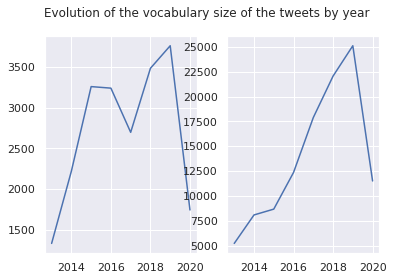

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Evolution of the vocabulary size of the tweets by year')
ax1.plot(range(2013,2021), l1)
ax2.plot(range(2013,2021), l2)

In [0]:
l1 = []
for k in range(1, 13):
  data_from = df_from.loc[df_from['month'] == k]
  arr_from = data_from.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_from:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l1.append(len(set(L1)))
  c_from = Counter(L1)
  d_from = pd.DataFrame(c_from, index=['occurrences']).transpose().reset_index()
  d_from.columns=['word', 'occurences']
  nb_total = d_from.occurences.sum()
  d_from['freq'] = d_from.occurences.apply(lambda x: x/nb_total)
  d_from = d_from.sort_values('freq', ascending=False)
  print(k)
  print(d_from['word'][0:10].to_list())
  print('-----')

print('-----------')

l2 = []
for k in range(1, 13):
  data_to = df_to.loc[df_to['month'] == k]
  arr_to = data_to.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_to:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l2.append(len(set(L1)))
  c_to = Counter(L1)
  d_to = pd.DataFrame(c_to, index=['occurrences']).transpose().reset_index()
  d_to.columns=['word', 'occurences']
  nb_total = d_to.occurences.sum()
  d_to['freq'] = d_to.occurences.apply(lambda x: x/nb_total)
  d_to = d_to.sort_values('freq', ascending=False)
  print(k)
  print(d_to['word'][0:10].to_list())
  print('-----')

1
['trafic', 'gare', 'train', 'ligne', 'entre', 'nord', 'cdg', '2', '1', 'perturbé']
-----
2
['trafic', 'ligne', 'gare', 'perturbé', 'entre', 'incident', "l'ensemble", 'cdg', 'train', 'nord']
-----
3
['trafic', 'ligne', 'gare', 'perturbé', 'train', 'cdg', 'entre', 'bonjour', "l'ensemble", 'incident']
-----
4
['trafic', 'gare', 'ligne', '2', 'cdg', 'train', 'nord', 'entre', 'incident', 'bonjour']
-----
5
['trafic', 'gare', 'entre', 'ligne', 'train', 'nord', 'perturbé', 'bonjour', '2', 'incident']
-----
6
['trafic', 'gare', 'train', 'ligne', 'nord', 'entre', 'perturbé', 'bonjour', 'bonne', 'journée']
-----
7
['trafic', 'ligne', 'gare', 'train', 'bonjour', 'entre', 'perturbé', 'cdg', 'bonne', "l'ensemble"]
-----
8
['trafic', 'ligne', 'gare', 'entre', 'perturbé', 'incident', 'bonjour', "l'ensemble", 'cdg', 'bonne']
-----
9
['trafic', 'ligne', 'gare', 'train', 'entre', "l'ensemble", 'perturbé', 'bonjour', 'incident', 'bonne']
-----
10
['trafic', 'ligne', 'gare', 'train', 'perturbé', "l'ense

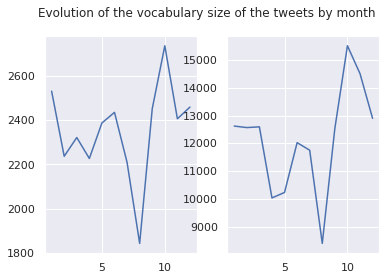

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Evolution of the vocabulary size of the tweets by month')
ax1.plot(range(1,13), l1)
ax2.plot(range(1,13), l2)

In [0]:
l1 = []
for k in range(1, 8):
  data_from = df_from.loc[df_from['day'] == k]
  arr_from = data_from.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_from:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l1.append(len(set(L1)))
  c_from = Counter(L1)
  d_from = pd.DataFrame(c_from, index=['occurrences']).transpose().reset_index()
  d_from.columns=['word', 'occurences']
  nb_total = d_from.occurences.sum()
  d_from['freq'] = d_from.occurences.apply(lambda x: x/nb_total)
  d_from = d_from.sort_values('freq', ascending=False)
  print(k)
  print(d_from['word'][0:10].to_list())
  print('-----')

print('-----------')

l2 = []
for k in range(1, 8):
  data_to = df_to.loc[df_to['day'] == k]
  arr_to = data_to.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_to:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l2.append(len(set(L1)))
  c_to = Counter(L1)
  d_to = pd.DataFrame(c_to, index=['occurrences']).transpose().reset_index()
  d_to.columns=['word', 'occurences']
  nb_total = d_to.occurences.sum()
  d_to['freq'] = d_to.occurences.apply(lambda x: x/nb_total)
  d_to = d_to.sort_values('freq', ascending=False)
  print(k)
  print(d_to['word'][0:10].to_list())
  print('-----')

1
['trafic', 'gare', 'ligne', 'train', 'nord', 'perturbé', 'cdg', 'entre', 'bonjour', 'bonne']
-----
2
['trafic', 'gare', 'ligne', 'train', 'entre', 'nord', 'perturbé', 'cdg', 'bonjour', "l'ensemble"]
-----
3
['trafic', 'gare', 'ligne', 'train', 'entre', 'nord', 'perturbé', 'cdg', 'bonjour', '2']
-----
4
['trafic', 'gare', 'ligne', 'train', 'entre', 'nord', 'perturbé', 'cdg', 'bonjour', "l'ensemble"]
-----
5
['trafic', 'gare', 'ligne', 'train', 'entre', 'nord', 'cdg', 'perturbé', 'bonjour', '2']
-----
6
['trafic', 'ligne', 'entre', 'gare', 'incident', 'nord', 'retour', "l'ensemble", 'perturbé', 'interrompu']
-----
7
['trafic', 'ligne', 'entre', 'gare', 'nord', 'incident', 'perturbé', '2', 'train', 'travaux']
-----
-----------
1
['a', 'train', 'merci', 'bonjour', "c'est", 'rer', 'gare', 'ça', 'plus', 'trains']
-----
2
['a', 'train', 'merci', 'bonjour', "c'est", 'ça', 'rer', 'gare', 'trains', 'plus']
-----
3
['a', 'merci', 'train', 'bonjour', 'gare', "c'est", 'ça', 'rer', 'trains', 'plus

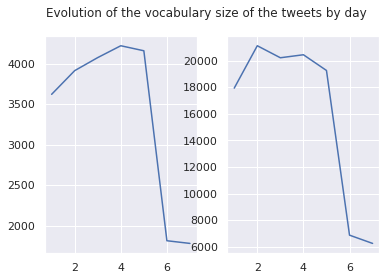

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Evolution of the vocabulary size of the tweets by day')
ax1.plot(range(1,8), l1)
ax2.plot(range(1,8), l2)

In [0]:
l1 = []
for k in range(1, 25):
  data_from = df_from.loc[df_from['hour'] == k]
  arr_from = data_from.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_from:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l1.append(len(set(L1)))
  c_from = Counter(L1)
  d_from = pd.DataFrame(c_from, index=['occurrences']).transpose().reset_index()
  d_from.columns=['word', 'occurences']
  nb_total = d_from.occurences.sum()
  d_from['freq'] = d_from.occurences.apply(lambda x: x/nb_total)
  d_from = d_from.sort_values('freq', ascending=False)
  print(k)
  print(d_from['word'][0:10].to_list())
  print('-----')

print('-----------')

l2 = []
for k in range(1, 25):
  data_to = df_to.loc[df_to['hour'] == k]
  arr_to = data_to.tweet.apply(lambda x: TweetTokenizer().tokenize(x)).array

  L1=[]
  for i in arr_to:
     L1+=i
  
  L1 = remove_html(L1)
  L1 = remove_url(L1)
  L1 = remove_pic(L1)
  L1 = [word.lower() for word in L1]
  L1 = [word for word in L1 if word not in stopwords.words("french")]
  L1 = [word for word in L1 if word not in ponctuation]
  L1 = [word for word in L1 if word not in words]
  l2.append(len(set(L1)))
  c_to = Counter(L1)
  d_to = pd.DataFrame(c_to, index=['occurrences']).transpose().reset_index()
  d_to.columns=['word', 'occurences']
  nb_total = d_to.occurences.sum()
  d_to['freq'] = d_to.occurences.apply(lambda x: x/nb_total)
  d_to = d_to.sort_values('freq', ascending=False)
  print(k)
  print(d_to['word'][0:10].to_list())
  print('-----')

1
['ligne', 'incident', 'trafic', 'travaux', 'terminé', 'retour', 'terminés', 'entre', 'intervention', 'régulier']
-----
2
['trafic', 'tardive', 'interrompu', 'entre', 'chantier', 'fin', 'ligne', 'gif', 'mitry', 'perturbé']
-----
3
['trafic', 'entre', 'ligne', 'tous', 'gare', 'perturbé', 'nord', 'vers', '2', "jusqu'à"]
-----
4
['trafic', 'ligne', 'bonjour', 'tous', "jusqu'à", 'bonne', 'journée', 'gare', 'accompagner', 'entre']
-----
5
['gare', 'trafic', 'train', 'bonjour', 'journée', 'bonne', 'ligne', 'nord', 'entre', "jusqu'à"]
-----
6
['gare', 'trafic', 'train', 'perturbé', 'suite', 'ligne', 'cdg', 'bonjour', 'nord', 'entre']
-----
7
['trafic', 'gare', 'ligne', 'train', 'perturbé', 'cdg', 'nord', 'voyageur', '2', 'suite']
-----
8
['trafic', 'gare', 'ligne', 'perturbé', 'train', 'nord', "l'ensemble", 'incident', 'entre', 'cdg']
-----
9
['trafic', 'gare', 'ligne', 'entre', 'nord', "l'ensemble", 'incident', 'retour', 'cdg', '2']
-----
10
['trafic', 'ligne', 'gare', 'entre', 'bonjour', "

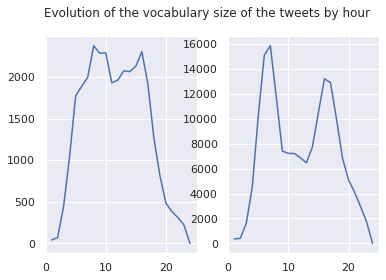

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Evolution of the vocabulary size of the tweets by hour')
ax1.plot(range(1,25), l1)
ax2.plot(range(1,25), l2)

Two conclusions are to be drawn from this section :

*   we see that the vocabulary size evolves in a globally similar way than the frequency of the tweets at the four time-scales,
*   we see that the analysis of the 10 most frequent words for groups of tweets constructed according to time variables in not very relevant. The ML approach will allow us to construc more relevant clusters to analyse the content of the tweets.







## II. Machine Learning part

### Using camemBERT to create an embedding of the tweets

In order to process the text of the tweets with some machine learning tool, we first need to vectorize it. To do so, we choosed to use the french version of BERT, camemBERT, imported with the *transformers* package. This model outputs for a tweet a vector of size 768. 

First, let's create some functions to clean up the tweets and remove all urls, emojis, pic references, hashtages.


In [0]:
import re
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
  
def remove_urls(string):
    vTEXT = re.sub(r'^((http|ftp|https)://)?([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', string, flags=re.MULTILINE)
    return(vTEXT)

def remove_pic(string):
  return re.sub(r'pic.twitter\S+', '', string)

def remove_hashtags(string):
  return string.replace('#','')

Now we can load the camemBERT model, clean up the data and use the model to get the output we want


In [10]:
from transformers import AutoModel, AutoTokenizer
import torch

MODEL_NAME = "camembert-base"
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()
list_text = df_from[df_from.is_reply == False].tweet.apply(remove_emoji).apply(remove_urls).apply(remove_hashtags).apply(remove_pic).to_list()

tokens = [tokenizer.encode_plus(i, return_tensors="pt") for i in list_text]
outputs = []
for i in tqdm(tokens):
  i['attention_mask']=i['attention_mask'].to('cuda')
  i['input_ids']=i['input_ids'].to('cuda')
  i['token_type_ids']=i['token_type_ids'].to('cuda')
model.to('cuda')
for i in tqdm(tokens):
  with torch.no_grad():
          outputs.append(model(**i)[1])
print(f"The size of the output vector is {outputs[1].shape}")
X = [np.array(i.cpu()).reshape(768) for i in outputs]



The size of the output vector is torch.Size([1, 768])


### Clusterization of the tweet-vectors




After comparaison of different clustering methods, we focus on K-means. Let's investigate the best number of cluster by looking at three metrics : the Calinksi-Harabasz index, the Davies-Bouldin index and the silhouette coefficient.

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
metric__ = []
metric2__ = []
metric3__ = []
mask = df_from[df_from.is_reply == False]
X_2019 = np.array(X)[(mask.year == 2019)]
for i in tqdm(range(0,30)):
  kmeans_model = KMeans(n_clusters=i+2, random_state=1).fit(X_2019)
  labels = kmeans_model.labels_
  metric__.append(metrics.calinski_harabasz_score(X, labels))
  metric2__.append(metrics.davies_bouldin_score(X, labels))
  metric3__.append(metrics.silhouette_score(X,labels))

len(X)

Text(0, 0.5, 'silhouette coefficient')

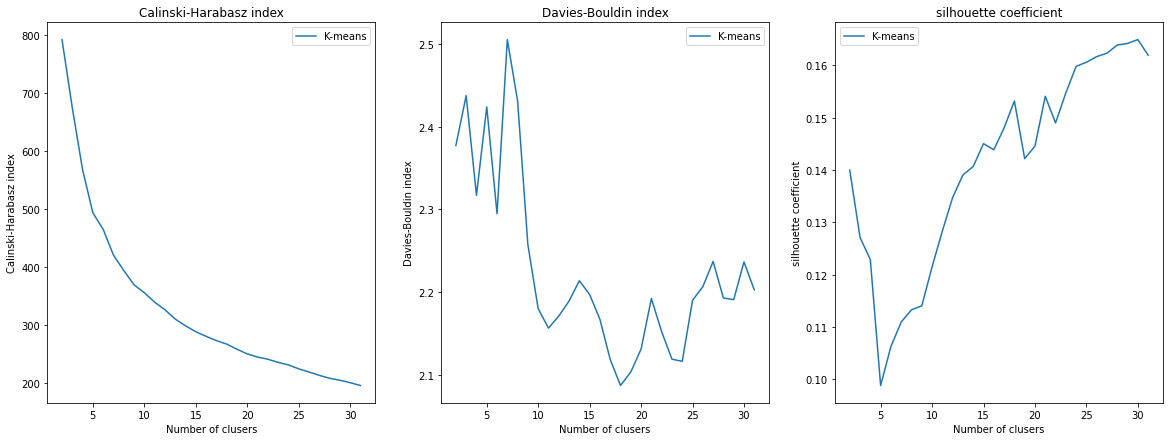

In [0]:
fig,ax = plt.subplots(1,3,figsize = (20,7))
abscisse = np.arange(2,32)

ax[0].plot(abscisse,metric__,label = "K-means")
ax[0].legend()
ax[0].set_title("Calinski-Harabasz index")
ax[0].set_xlabel("Number of clusers")
ax[0].set_ylabel("Calinski-Harabasz index")

ax[1].plot(abscisse,metric2__,label = "K-means")
ax[1].legend()
ax[1].set_title("Davies-Bouldin index")
ax[1].set_xlabel("Number of clusers")
ax[1].set_ylabel("Davies-Bouldin index")

ax[2].plot(abscisse,metric3__,label = "K-means")
ax[2].legend()
ax[2].set_title("silhouette coefficient")
ax[2].set_xlabel("Number of clusers")
ax[2].set_ylabel("silhouette coefficient")

The Calinski-Harabasz is still not very informative about the size of the cluster, but the Davies-Bouldin index and the silhouette may be informative :  we will use 18 clusters : the global minimum for DB and a local maximum for silhouette

### Visualization of the clustering



In order to visualize the clusters we just made, we have to transform the space of 768-vectors to the 2D plane. We compare the results obtained with TSNE and PCA. First the TNSE :

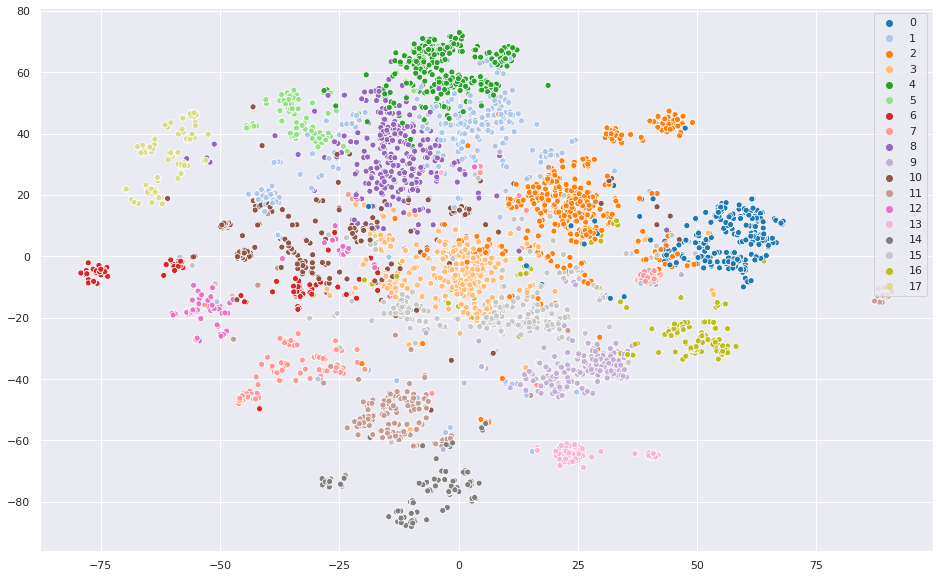

In [11]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.manifold import TSNE
n_clusters = 18
mask = df_from[df_from.is_reply == False]
X_2019 = np.array(X)[(mask.year == 2019)]
ml = KMeans(n_clusters=n_clusters)
Y = ml.fit_predict(X_2019)
X_embedded = TSNE(n_components=2).fit_transform(X_2019)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=Y,
    palette=sns.color_palette("tab20", n_clusters))

Now the PCA :

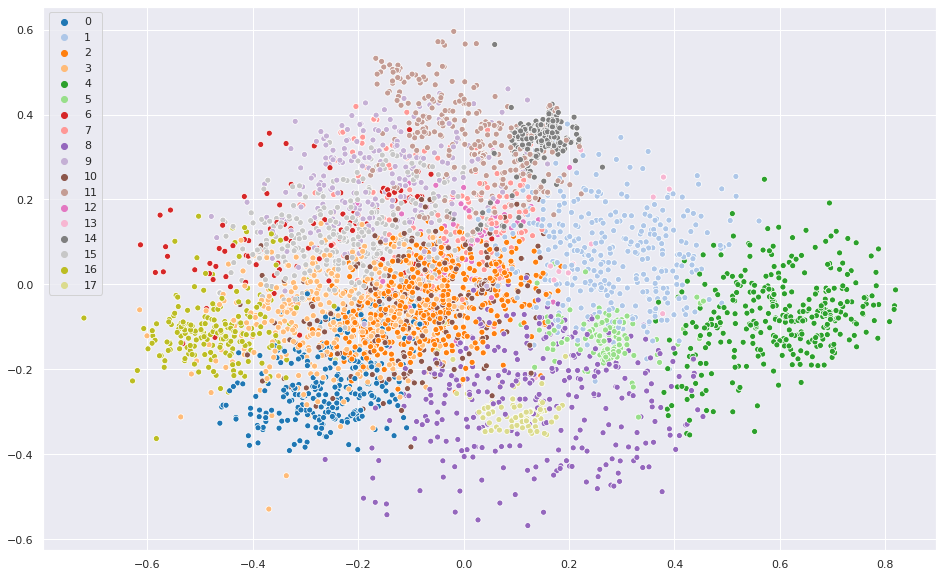

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X_2019)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=Y,
    palette=sns.color_palette("tab20", n_clusters))

We see that the TNSE better seperates the clusters, that are for some, very well seperated from the others. To have a better idea of what each cluster represent, let's draw a wordcloud for every cluster.

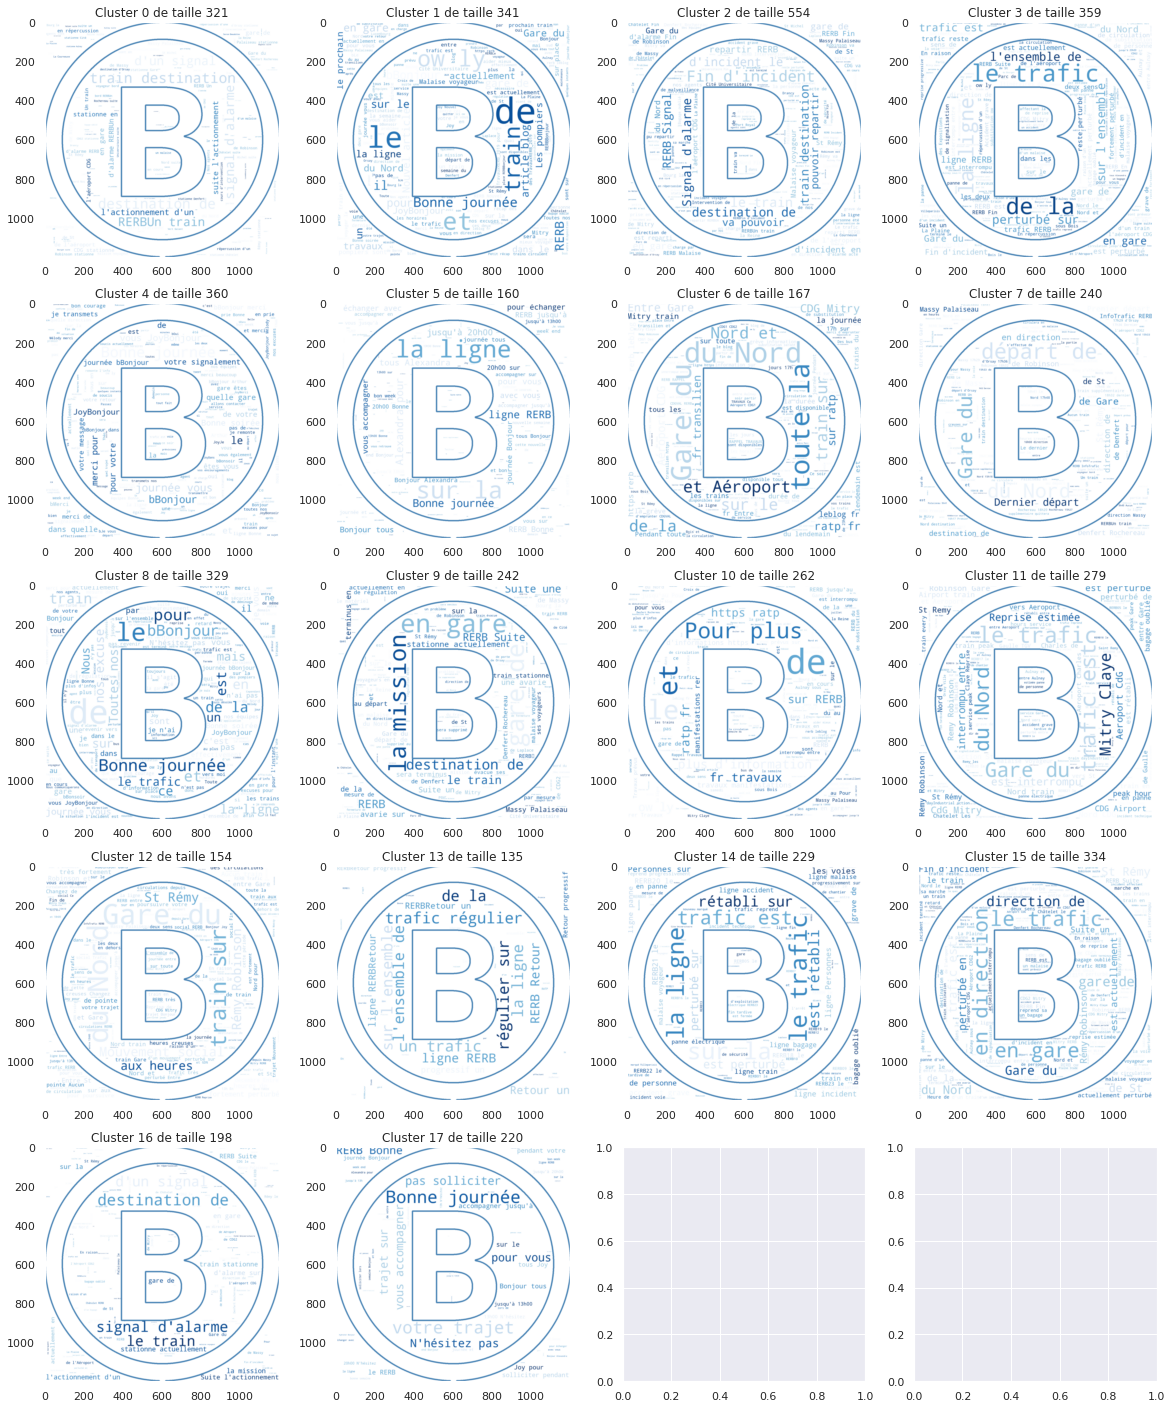

In [19]:
from wordcloud import WordCloud,STOPWORDS
from functools import reduce
from operator import add
from PIL import Image

img = np.array(Image.open('/content/drive/My Drive/rerb.png'))[:,:,:3]
n_col = 4
n_ligne = 5
fig,ax = fig, ax = plt.subplots(n_ligne,n_col,figsize=(20,25))

df2 = df_from[(df_from.is_reply == False) & (df_from.year == 2019)].tweet.apply(remove_emoji).apply(remove_urls).apply(remove_hashtags).apply(remove_pic)
for i in range(n_clusters):
  text_cloud = reduce(add, df2[Y==i]) 
  size = len(df2[Y==i])
  # Generate a word cloud image
  wordcloud = WordCloud(background_color="white",mask=255-img,
                        #stopwords = ['le','la','est'],
                        contour_width=10, contour_color='steelblue', colormap = "Blues_r").generate(text_cloud)
  ax[i//n_col,i%n_col].imshow(wordcloud, interpolation='bilinear')
  ax[i//n_col,i%n_col].set_title(f"Cluster {i} de taille {size}")
  ax[i//n_col,i%n_col].grid(False)

We can interpret the cluster as follows : 
- cluster 0 : words associated to traffic perturbations due to the activation of an alarm signal
-cluster 1 : words associated to traffic perturbations linked to a “malaise voyageur’
-cluster 2 : words associated to the traffic progressively going back to normal
-cluster 3 : words associated to daily incidents on the traffic
-cluster 4 : words associated to messages from one of the two community managers proposing help and answering questions
-cluster 5 : same as cluster 4 (community manager)
-cluster 6 : indistinct information words
-cluster 7 : words associated to information about the first and last departures
-cluster 8 : same as cluster 4 (community manager)
-cluster 9 : same as cluster 3 (daily incidents)
-cluster 10 : words associated to information about future maintenance works on the line
-cluster 11 : same as cluster 3 (daily incidents)
-cluster 12 : same as cluster 6 (indistinct information)
-cluster 13 : same as cluster 2 (traffic going back to normal)
-cluster 14 : same as cluster 2 (traffic going back to normal)
-cluster 15 : same as cluster 3 (daily incidents)
-cluster 16 : same as cluster 0 (alarm signal)
-cluster 17 : same as cluster 4 (community manager)

We can conclude that some kinds of messages are quite clearly distinct from the others : the ones from the CM,, the one announcing planned works…
But the messages announcing daily incidents causing perturbations and the traffic going back to normal are much more indistinct from each other.


## III. Sentiment analysis of the replies

Our last idea was to do a sentiment analysis of the replies of random users to the RERB. We choose to predict three classes : 0 for negative, 1 for neutral and 2 for postive. To have a benchmark and a dataset to train a model, we classified by hand 3600 tweets from to pool of replies. We obtained the following classification :


In [0]:
df_class.sentiment.value_counts()

1.0    1660
0.0    1624
2.0     349
Name: sentiment, dtype: int64

We obtained almost as neutral and as negative replied, and around 10% of positive (so around 45%,45%,10%). The first issue with the hand labelling is that even for a humain it is a difficult task : some tweets seem sarcastic but without the context it may be hard to know.

Our first idea was to fine-tune camembert or another model of the sort, but we did not manage to have a proper convergence of the optimization part. So, we will use the embedded tweets as in the previous section to use classic machine learning algorithms.

### Classification on our hand labelled data

In [12]:
from sklearn.model_selection import train_test_split
df_class.tweet = df_class.tweet.apply(remove_emoji).apply(remove_hashtags).apply(remove_urls).apply(remove_pic).apply(str.lower)
train, test = train_test_split(df_class[df_class.tweet.apply(len)>2], test_size=0.2)

from transformers import AutoModel, AutoTokenizer
import torch

MODEL_NAME = "camembert-base"
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()
train_list= train.tweet.to_list()
test_list= test.tweet.to_list()

def embedding(list_tweet):
  tokens = [tokenizer.encode_plus(i, return_tensors="pt") for i in list_tweet]
  outputs = []
  for i in tokens:
    i['attention_mask']=i['attention_mask'].to('cuda')
    i['input_ids']=i['input_ids'].to('cuda')
    i['token_type_ids']=i['token_type_ids'].to('cuda')
  model.to('cuda')
  for i in tqdm(tokens):
    with torch.no_grad():
            outputs.append(model(**i)[1])
  return np.array([np.array(i.cpu()).reshape(768) for i in outputs])

X_train = embedding(train_list)
X_test = embedding(test_list)
y_train = train.sentiment.to_numpy()
y_test = test.sentiment.to_numpy()

Now we have our train/test vectors and label, let's use the XGBoost classifier

              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75       305
         1.0       0.75      0.72      0.73       339
         2.0       0.87      0.60      0.71        77

    accuracy                           0.74       721
   macro avg       0.77      0.70      0.73       721
weighted avg       0.74      0.74      0.74       721



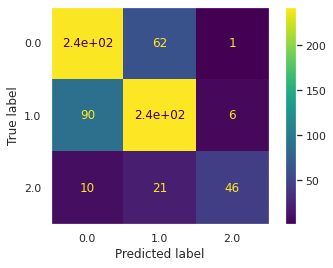

In [14]:
from xgboost import XGBClassifier
from sklearn import metrics
classifier = XGBClassifier()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test,y_pred))
metrics.plot_confusion_matrix(classifier,X_test,y_test)
plt.grid(False)

### Use of the classifier to infer the influence of the cluster on the mean sentiment.


Now let's use this model to see the impact of the cluster on the mean sentiment of the replies. 

In [23]:
sentiments = []
for i in tqdm(range(n_clusters)):
  df_only_reply = df_from[(df_from.is_reply == False) & (df_from.year == 2019)]
  conv_id = df_only_reply[Y==i].conversation_id.unique()
  df_cluster =  df_to[df_to.conversation_id.isin(conv_id)]
  df_cluster.tweet = df_cluster.tweet.apply(remove_emoji).apply(remove_hashtags).apply(remove_urls).apply(remove_pic).apply(str.lower)
  X_cluster = embedding(df_cluster.tweet.to_list())
  sentiments.append(classifier.predict(X_cluster))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Let's calculate the mean of the sentiment per cluster

In [0]:
mean = [i.mean() for i in sentiments]
n_reply = [len(i) for i in sentiments]
sums = [i.sum() for i in sentiments]
global_mean = np.sum(sums)/np.sum(n_reply)

In [32]:
mean

[0.4546553808948005,
 0.6197661259901924,
 0.5395417590539542,
 0.5047691720717283,
 0.7648190916089299,
 0.8602150537634409,
 0.8700173310225303,
 0.8289719626168224,
 0.6526743398781314,
 0.4298780487804878,
 0.5253130103429504,
 0.5986307231493367,
 0.8622327790973872,
 0.5501165501165501,
 0.43706777316735823,
 0.4824561403508772,
 0.44198174706649285,
 0.8326547231270358]

In [34]:
global_mean

0.6266722175964474

We observe firstly that the average reactions to the RERB tweets are quite negative.
We observe that the clusters associated to live information about incidents have relatively bad grades : clusters 0, 9, 16 are graded more or less 0.4,  whereas the messages from the community managers have relatively good grades. We can conclude that users prefer personalised answer to specific questions than general and indistinct information.
We notice a few incoherences though, that should make us cautious of our results, for example that the clusters that we classified as associated to the traffic going back to normal (2,13 and 14) have relatively bad grades.


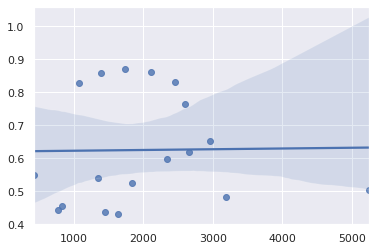

In [31]:
sns.regplot(x=n_reply,y=mean)

As we can see, there is no direct correlation between the number of replies and the length of the tweet.
